In [11]:
import pandas as pd
import gensim
from gensim.models import Word2Vec
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk import word_tokenize
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
stop_words = stopwords.words('english')
from pyemd import emd
from sklearn.cluster import DBSCAN, AffinityPropagation, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, kneighbors_graph
import pickle
import matplotlib.pyplot as plt

In [10]:
class Embeddings:
    
    def __init__(self, create=False, ser_model_path='W2VModel',
                 embeddings='GoogleNews-vectors-negative300.bin.gz',
                 model_fun=gensim.models.KeyedVectors.load_word2vec_format, binary=True, norm=True):
        self.ser_model = ser_model_path
        self.embeddings = embeddings
        self.model_fun = model_fun
        self.binary = binary
        self.norm = norm
        
        if create == False:
            self.model = self.load_model()
        else:
            self.model = self.create_model()
        
            
    def create_model(self):
        model = self.model_fun(self.embeddings, binary=self.binary)
        if self.norm:
            model.init_sims(replace=True)
        return model
            
    def load_model(self):
        with open(self.ser_model, 'rb') as file:
            model = pickle.load(file)
        return model

In [13]:
class News_Vectorizer:
    
    def __init__(self, model, news=None):
        self.news = news #array of strings
        self.model = model #Word2Vec model
        if self.news is not None:
            self.news_vectors = self.news2vec(self.news) #vector representations
        else:
            self.news_vectors = None
        self.cos_dist = None #cosine distance matrix
        self.wm_dist = None #wmd-matrix
    
    def wmd(self, q1, q2):
        q1 = str(q1).lower().split()
        q2 = str(q2).lower().split()
        q1 = [w for w in q1 if w not in stop_words]
        q2 = [w for w in q2 if w not in stop_words]
        return self.model.wmdistance(q1, q2)
    
    def sent2vec(self, s):
        words = str(s).lower()
        words = word_tokenize(words)
        words = [w for w in words if not w in stop_words]
        words = [w for w in words if w.isalpha()]
        M = []
        for w in words:
            try:
                M.append(self.model[w])
            except:
                continue
        M = np.array(M)
        v = M.sum(axis=0)
        return v / np.sqrt((v ** 2).sum())
    
    def news2vec(self, news):
        # update self.news, self.news_vectors
        news_vectors = np.array([self.sent2vec(text) for text in news])
        self.news = news
        self.news_vectors = news_vectors
        return news_vectors
    
    def dist_vec(self, news_item, news=None, metric='cosine'):
        #computes distances between given item and news (or self.news)
        news_item = self.sent2vec(news_item)
        if news is not None:
            news = self.news2vec(news)
        else:
            news = self.news_vectors
        if news is None:
            return 'no news to compute distances'
        if metric == 'cosine':
            dist_vec = np.array([cosine(news_item, i) for i in news])
        elif metric == 'wmd':
            dist_vec = np.array([self.wmd(news_item, i) for i in news])
        return dist_vec
    
    def cosine_matrix(self): 
        cdist = np.zeros((len(self.news_vectors), len(self.news_vectors)))
        for n, i in enumerate(self.news_vectors):
            for m, j in enumerate(self.news_vectors):
                cdist[n, m] = cosine(i, j)
        self.cos_dist = cdist
        return cdist
    
    def wmd_matrix(self): #list (news)
        wmdist = np.zeros((len(self.news), len(self.news)))
        for n, i in enumerate(self.news):
            for m, j in enumerate(self.news):
                wmdist[n, m] = self.wmd(i, j)
        self.wm_dist = wmdist
        return wmdist

## Classifier & Clusterizer

* Samples of interesting news from different people
* Try to find a meaningful threshold for AgglomerativeClustering 
![](agg_clustering_complete_linkage_300.png "Complete Linkage")
* AND a meaningful radius for RadiusNeighbours (parameter grid -> CV on each sample -> mean -> best radius)
![](radiusneighbors.png "radius")

### Daten 

https://github.com/DariaDLA/Analysewerkzeuge_Python_Team/tree/master/classified_data_samples  

**Die bearbeiteten DataFrames mit unique news:**  

sample_unique_0.csv ... sample_unique_5.csv
  
**Und Vektorrepräsentationen von "interessanten" Nachrichten:**  
  
news_vec0  ... news_vec5

**Dazugehörige Distanzen:**  

cosine_dist0 ... cosine_dist5  

**Vektorrepräsentationen und Distanzen sind mit `pickle` einzulesen:**  

`with open('.\\cosine_dist0', 'rb') as file:
    cosine_dist0 = pickle.load(file)`  
    
`with open('.\\news_vec0', 'rb') as file:
    news_vec0 = pickle.load(file)`  
    

#### Distance threshold AgglomerativeClustering

In [29]:
# DataFrame mit unique news einlesen

sample0 = pd.read_csv('.\\data_samples\\sample_unique_0.csv')

In [58]:
sample0.head(5)

,ID,is_interesting,news,category
0,005503512f38f130303cb133d656203b,1,What 2020 holds for Scottish politics. After a...,BBC News - UK Politics
1,007b36b1081c3dddafe8869961ded463,0,London council's special needs inquiry caused ...,BBC News - Family & Education
2,0090dbe2404af0f2ee72ac4ea1a7376a,0,'Resistant' trees planted in Hampshire in ash ...,BBC News - Science & Environment
3,00d684e0145b5fb5f15adbcb5fc23ee4,0,Primary league tables: How did your school do?...,BBC News - Family & Education
4,01ed4160c0609908173d1fa04fc77cf8,0,The problem with celebrating tennis' most succ...,BBC News - Home


In [59]:
sample0.shape

(251, 4)

In [31]:
# Vektorrepräsentation von "interessanten" Nachrichten einlesen

with open('.\\data_samples\\news_vec0', 'rb') as file:
    news_vec0 = pickle.load(file)

In [32]:
news_vec0

array([[ 0.02461345,  0.05201338,  0.00493424, ..., -0.01758986,
         0.0651383 ,  0.05141929],
       [ 0.00566244,  0.0558705 ,  0.03648809, ...,  0.05095945,
         0.06740265,  0.00038223],
       [ 0.02608637,  0.05796345, -0.01567714, ...,  0.03309522,
         0.0897331 , -0.02731742],
       ...,
       [-0.03423567,  0.02955162,  0.00781678, ..., -0.10761527,
        -0.01768852, -0.01545603],
       [ 0.0674457 ,  0.09843922, -0.03518565, ..., -0.07708695,
         0.04436256, -0.07325413],
       [ 0.03075207,  0.04851424,  0.00330401, ...,  0.05915262,
        -0.01834202, -0.01268486]], dtype=float32)

In [33]:
# Vektor mit cosine Distanzen zwischen interessanten Nachrichten einlesen

with open('.\\data_samples\\cosine_dist0', 'rb') as file:
    cosine_dist0 = pickle.load(file)

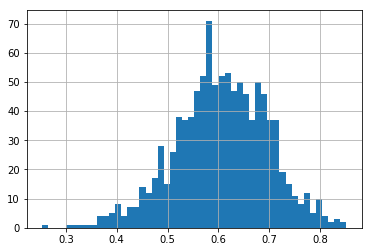

In [36]:
pd.Series(cosine_dist0).hist(bins=50)

In [37]:
# threshold definieren

# Bitte beachte hier die richtige Eingabe von cosine_dist0 ... cosine_dist4, 
# wenn Du unterschiedliche Daten untersuchen wirst

THRESHOLD = np.quantile(cosine_dist0, 0.7)

In [38]:
# AgglomerativeClustering Instanz

agg_clust = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='complete', distance_threshold=THRESHOLD)

In [39]:
# Clustering

agg_clust.fit(news_vec0)

AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',
                        connectivity=None,
                        distance_threshold=0.6552909135818481,
                        linkage='complete', memory=None, n_clusters=None,
                        pooling_func='deprecated')

In [40]:
# Cluster labels

agg_clust.labels_

array([ 5, 10,  8,  7,  8,  5,  8,  6,  3,  8,  0,  6, 10,  5,  8,  6,  0,
        6,  6,  1,  0,  5,  4,  1,  3,  0,  1, 10,  8,  2,  2,  3,  8,  3,
        4,  1,  4,  9,  1,  1,  1,  2,  3,  2, 11, 10], dtype=int64)

In [41]:
# "interessante" Nachrichten mit cluster labels

tmp = sample0.query('is_interesting > 0').copy()
tmp['label'] = agg_clust.labels_

In [42]:
# einzelne cluster labels wählen

tmp.query('label == 0') # Gesundheit

,ID,is_interesting,news,category,label
85,519b4d14f334483fd42c5ca92a0dc289,1,Why are opioids still given for chronic pain?....,BBC News - Health,0
115,74988745bcefc5c8d73364321c770ce7,1,Smart contact lens: 'It feels seriously sci-fi...,BBC News - Technology,0
134,8deddf3aeaef732fe086f09a93c8295f,1,Is it OK to call in sick with a common cold?. ...,['BBC News - Business' 'BBC News - Health'],0
148,9add850f74d420d2c6a4bbd5dd6cda9e,1,Does music make exercise more effective?. Trus...,BBC News - Health,0


In [44]:
tmp.query('label == 2') # - Musik, Unterhaltung

,ID,is_interesting,news,category,label
173,b10e055fbb52bc696883245518c45223,1,James Bond's greatest hits - and biggest misse...,BBC News - Entertainment & Arts,2
176,b51afe8886c1363f43e25a60220f41b8,1,Five ways music changed in the 2010s. Songs be...,BBC News - Home,2
227,e4566e9bef272bd0dab80bd03304a549,1,Spotify's personalised playlist for pets and o...,BBC News - Technology,2
237,ede253dfb006bab60e741c8b8d5adb23,1,David Bowie: Unseen footage released by De Mon...,BBC News - Entertainment & Arts,2


In [48]:
tmp.query('label == 6') # ? Naturkatastrophen

,ID,is_interesting,news,category,label
41,238b07b98cafe310dbd1d72110fb9100,1,Taal volcano's inner lake all but gone in erup...,['BBC News - Science & Environment' 'BBC News ...,6
87,5371fa52cc4422aa7c6734f04b2b50fa,1,Australia fires: Is arson to blame?. There has...,BBC News - Home,6
109,6c1534836b05c8f92bb144d72d270bab,1,Australia fires: Vineyard owner's grief and de...,BBC News - Business,6
122,7a29e78099ab2040e760ef9b7a82e7bd,1,US officials ground drones over espionage fear...,['BBC News - Home' 'BBC News - Technology'],6
130,8a366f8510fc7cfa0b128808aa932a45,1,Australia fires: How do we know how many anima...,BBC News - Science & Environment,6


In [54]:
tmp.query('label == 11') 

,ID,is_interesting,news,category,label
239,f58971b71f27d6f94a9108efdc77f83f,1,Portrait of a Lady: Painting found in wall con...,['BBC News - Home' 'BBC News - World'],11


In [52]:
tmp.query('label == 10') # Klimawandel

,ID,is_interesting,news,category,label
6,06113c818fdff9e1076d7ce19c60709a,1,Climate change: Can Glasgow go carbon neutral?...,['BBC News - Home' 'BBC News - Science & Envir...,10
89,53bf0c9b9b0d9ba208af31486aab8444,1,"Climate change: Should you fly, drive or take ...",BBC News - Home,10
157,a279e3fa0d124c1359408f34fdfedbdd,1,What's your diet's carbon footprint?. Check th...,['BBC News - Home' 'BBC News - World'],10
244,fa48614986378944380ac155947c3812,1,Can Microsoft's 'moonshot' carbon goal succeed...,['BBC News - Home' 'BBC News - Technology' 'BB...,10


In [57]:
tmp.query('label == 1') # ? kein bestimmtes Thema

,ID,is_interesting,news,category,label
132,8c6a9769fe859c0bdf025bfa996eece9,1,Climate change explained. It's been linked to ...,['BBC News - Home' 'BBC News - World'],1
140,90ff1928e913774b4dddc8d46647b460,2,"Social media data needed for 'harm' research, ...",['BBC News - Family & Education' 'BBC News - H...,1
155,a0588090bfc0ee8b1b13439ec93d44d9,1,COP26: Climate summit policing will cost more ...,BBC News - Home,1
196,cdd1a893f1ce1b77c33468f770f22b85,1,Facial recognition: EU considers ban of up to ...,BBC News - Technology,1
208,d6bc8c7a5f1bef8b31710a29199de422,1,The man who got rich on data - years before Go...,BBC News - Technology,1
209,d6d1c8f00eb2d01d2bd98a90cf8c720d,1,Erasmus: What could happen to scheme after Bre...,['BBC News - Family & Education' 'BBC News - U...,1
211,d7f98ae50187f23f0db81ea4cee73ba2,1,Climate change: What can I do about it and oth...,['BBC News - Home' 'BBC News - Science & Envir...,1


_Threshold quantile(0.7) erscheint plausibel_

#### Radius for RadiusNeighborsClassifier

In [1]:
samples = []
sample_names = ['sample_unique_' + str(i) + '.csv' for i in range(6)]

In [5]:
for sname in sample_names:
    samples.append(pd.read_csv('.\\data_samples\\'+sname))

In [7]:
samples[1].head(10)

,ID,is_interesting,news,category
0,005503512f38f130303cb133d656203b,1,What 2020 holds for Scottish politics. After a...,BBC News - UK Politics
1,007b36b1081c3dddafe8869961ded463,1,London council's special needs inquiry caused ...,BBC News - Family & Education
2,0090dbe2404af0f2ee72ac4ea1a7376a,1,'Resistant' trees planted in Hampshire in ash ...,BBC News - Science & Environment
3,00d684e0145b5fb5f15adbcb5fc23ee4,0,Primary league tables: How did your school do?...,BBC News - Family & Education
4,01ed4160c0609908173d1fa04fc77cf8,0,The problem with celebrating tennis' most succ...,BBC News - Home
5,043d4121f98949800bfd5332c83de874,0,Sheffield students paid to tackle racist langu...,BBC News - Family & Education
6,06113c818fdff9e1076d7ce19c60709a,1,Climate change: Can Glasgow go carbon neutral?...,['BBC News - Home' 'BBC News - Science & Envir...
7,07dc65d05bdc97a4124ee5535359b096,0,Arfield and Defoe see Rangers past Stranraer i...,BBC News - Home
8,09ad9ac0c69ca1454d071fcd88c93d66,0,Sunderland woman left bloodied after 'homophob...,BBC News - UK
9,0a35f79b90d245f970bfc721f2dd5018,1,Microsoft makes 'carbon negative' pledge. The ...,['BBC News - Business' 'BBC News - Science & E...


In [14]:
nv = News_Vectorizer(Embeddings().model)

In [15]:
news_vectors = []
for sample in samples:
    news_vectors.append(nv.news2vec(sample.news.values))

In [16]:
cosine_dist = []
fnames = ['cosine_dist'+str(i) for i in range(6)]

In [17]:
for fname in fnames:
    with open('.\\data_samples\\'+fname, 'rb') as file:
        cosine_dist.append(pickle.load(file))

In [18]:
ind_interest = []
ind_other = []
for sample in samples:
    ind_interest.append(np.where(sample.is_interesting > 0)[0])
    ind_other.append(np.where(sample.is_interesting == 0)[0])
    

In [19]:
thresholds = [np.quantile(cosine_dist[i], 0.7) for i in range(len(cosine_dist))]

In [20]:
interest_news_vectors = [news_vectors[i][ind_interest[i]] for i in range(len(news_vectors))]

In [21]:
labels = []
for n, sample in enumerate(interest_news_vectors):
    agg = AgglomerativeClustering(n_clusters=None, affinity='cosine', 
                                           linkage='complete', distance_threshold=thresholds[n])
    agg.fit(sample)
    labels.append(agg.labels_)

In [22]:
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, roc_auc_score

In [23]:
rad = np.arange(0.4, 0.52, 0.01)

In [160]:
rad

array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51])

In [24]:
rs = ShuffleSplit(n_splits=5, test_size=.1, random_state=0)

In [25]:
scores = []
for radius in rad:
    rad_scores = []
    clf = RadiusNeighborsClassifier(radius=radius, weights='distance', metric='cosine', outlier_label='-1')
    for n, sample in enumerate(interest_news_vectors):
        sample_scores = []
        for train_ind, test_ind in rs.split(sample):
            clf.fit(sample[train_ind], labels[n][train_ind])
            pred = clf.predict(sample[test_ind])
            sample_scores.append(accuracy_score(labels[n][test_ind], pred))
        rad_scores.append(np.mean(sample_scores))
    scores.append(np.mean(rad_scores))    

In [26]:
max(scores)

0.62

In [192]:
pred

array([13,  1,  1,  1,  0, 13,  5], dtype=int64)

In [27]:
rad[np.where(scores == max(scores))]

array([0.49])